<a href="https://colab.research.google.com/github/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Necessary imports to configure the environment.

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
from google.colab import files

Getting the Dataset from the Github repository:

In [2]:
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Dataset/P2_measurements.zip
!unzip P2_measurements.zip -d P2_measurements

--2021-11-18 14:09:55--  https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Dataset/P2_measurements.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/main/Dataset/P2_measurements.zip [following]
--2021-11-18 14:09:56--  https://raw.githubusercontent.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/main/Dataset/P2_measurements.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9358428 (8.9M) [application/zip]
Saving to: ‘P2_measurements.zip’

P2_measurements.zip 100%[===================>]   8.92

The Hysteresis Dataset is downloaded from the Github repository and stored into a dictionary. Each DataFrame is normalized between -1 and 1

In [3]:
cwd = "/content/P2_measurements"

# Set the following flag to True to consider the whole Hysteresis Curve, including
# the first Magnetization curve.
first_magnetization = False

# The scaler is used to rescale the dataset values between -1 and 1
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Creating a dictionary containing all the measurements divided by frequency
dataset = {}
columns = ["t", "B", "H", "-H"] # t: timestamp, B: Magnetic Flux Density, H: Magnetic Field 

for file in os.listdir(cwd):
    temp_data = pd.read_csv(os.path.join(cwd, file),sep=';', header=None, names=columns)
    # Normalizing the Dataset 
    temp_data_norm = pd.DataFrame(scaler.fit_transform(temp_data[['H', 'B']]), columns=['H', 'B']) 
    if first_magnetization:
        dataset[file] = temp_data_norm
    else:
        # Select only the second half of the curve
        dataset[file] = temp_data_norm[int(len(temp_data)/2):].reset_index(drop=True)

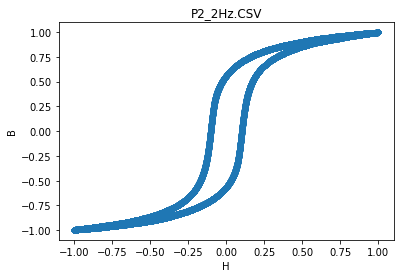

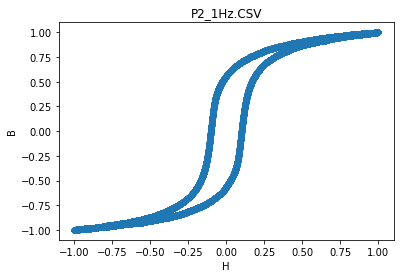

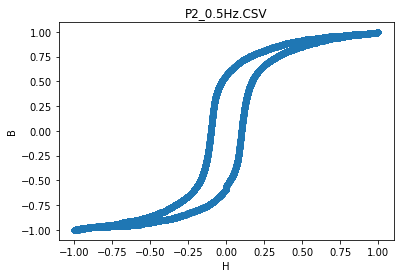

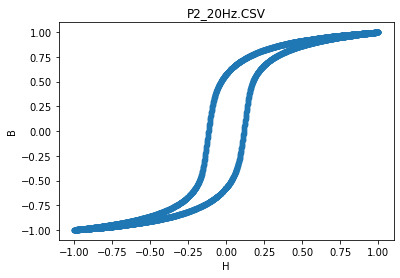

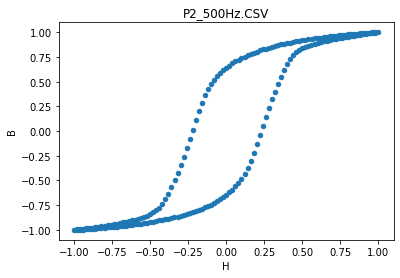

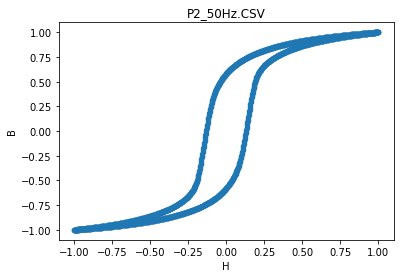

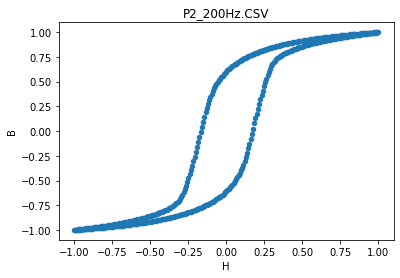

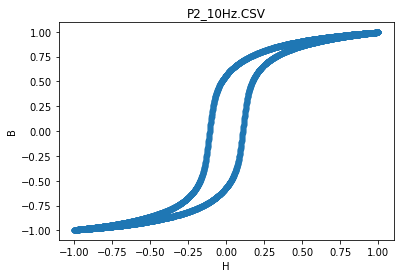

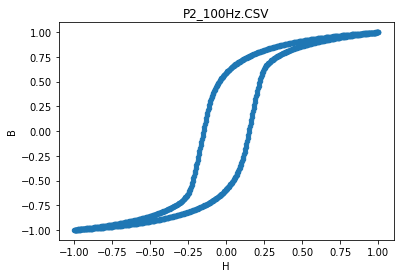

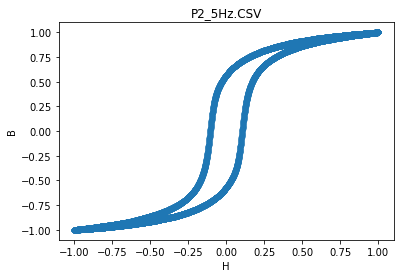

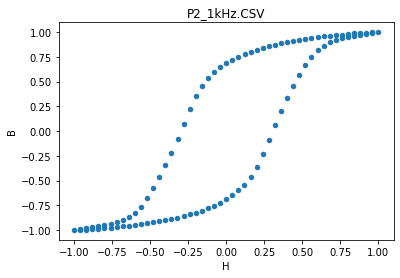

In [ ]:
# Plotting the normalized Dataset
for freq in dataset:
    dataset[freq].plot.scatter('H', 'B', title=freq)

# dRNN Model Training:

This notebook contains the preliminary tests: different strategies to train the dRNN are here explored, trying to understand how to proceed.

First, the model is trained over a single the Hysteresis loop measured for an input at a given frequency.

In [4]:
# Defining some of the Network and Sequence parameters:
# For training purposes, the sequence length is fixed to 20
seq_len = 20
batch_size = len(dataset)

Training batches are created according to the following structure:

```
Batch 0 = [sample_0.5Hz_from_t0_to_t20, sample_1Hz_from_t0_to_t20, ..., sample_1kHz_from_t0_to_t20]

Batch 1 = [sample_0.5Hz_from_t20_to_t40, sample_1Hz_from_t20_to_t40, ..., sample_1kHz_from_t20_to_t40]

Batch 2 = ...
```
Each batch contains samples related to different input frequencies, for a total of 11 samples: each sample contains ```seq_len = 20``` timesteps.




In [5]:
batches = []

for i in range(0, 200000, seq_len):
    batch_X = []
    batch_Y = []
    for freq in dataset:
        
        X = np.array(dataset[freq].iloc[(i % len(dataset[freq])):(i % len(dataset[freq])) + seq_len][['H']])
        Y = np.array(dataset[freq].iloc[(i % len(dataset[freq])):(i % len(dataset[freq])) + seq_len][['B']])
        
        batch_X.append(X)
        batch_Y.append(Y)
    
    batches.append([batch_X, batch_Y])

batches = np.array(batches)

Save the computed batches

In [ ]:
# Save the computed batches to a .npy file
np.save('batches', batches)

Load the computed batches from local file

In [ ]:
uploaded = files.upload()

In [ ]:
batches = np.load('/content/batches.npy')

The WindowGenerator Class can:

1. Handle the indexes and offsets.
2. Split windows of features into (features, labels) pairs.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Datasets`.

The following code is inspired from https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=None, test_df=None,
               label_columns=None, feature_columns=None, sequence_stride=1, batch_size=1):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.feature_columns = feature_columns
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        self.batch_size = batch_size
        self.sequence_stride = sequence_stride

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        # This customization allows to select the features to use as input, by properly setting
        # the feature_columns argument   
        if self.label_columns is not None:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.feature_columns],
                axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=self.total_window_size,
                sequence_stride=self.sequence_stride,
                shuffle=False,
                batch_size=self.batch_size)

        ds = ds.map(self.split_window)

        return ds

In [ ]:
# Instantiating a window class
wide_window = WindowGenerator(
    input_width=seq_len, label_width=seq_len, shift=0,
    label_columns=['B'], feature_columns=['H'], 
    sequence_stride = seq_len, batch_size=batch_size)

wide_window

In [ ]:
# Building the tf.data.Dataset
train_data = wide_window.make_dataset(train_df)

In [ ]:
# Instantiating an iterator over the training dataset
iterator = iter(train_data)  

In [ ]:
features, labels = next(iterator)
print("Features batch:" + str(features))
print("Labels batch:" + str(labels))

In [6]:
class DiagonalRNNCell(tf.keras.layers.SimpleRNNCell):
    def __init__(self, **kwargs):
        super(DiagonalRNNCell, self).__init__(recurrent_initializer='glorot_uniform',
                                              **kwargs)
    
    # Overriding the build method 
    def build(self, input_shape):
        super(DiagonalRNNCell, self).build(input_shape)

        # Override only the recurrent kernel 
        self.recurrent_kernel = self.add_weight(
            shape=(self.units,),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

    # Overriding the call method    
    def call(self, inputs, states, training=None):
        prev_output = states[0] if tf.nest.is_nested(states) else states
        dp_mask = self.get_dropout_mask_for_cell(inputs, training)
        rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
            prev_output, training)

        if dp_mask is not None:
            h = tf.keras.backend.dot(inputs * dp_mask, self.kernel)
        else:
            h = tf.keras.backend.dot(inputs, self.kernel)
        if self.bias is not None:
            h = tf.keras.backend.bias_add(h, self.bias)

        if rec_dp_mask is not None:
            prev_output = prev_output * rec_dp_mask
        # The Tensor product becomes a vector element-wise product
        output = h + prev_output * self.recurrent_kernel
        if self.activation is not None:
            output = self.activation(output)

        new_state = [output] if tf.nest.is_nested(states) else output
        return output, new_state

Model: "dRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(11, 20, 1)]             0         
                                                                 
 rnn (RNN)                   (11, 20, 256)             768       
                                                                 
 dense (Dense)               (11, 20, 1)               257       
                                                                 
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


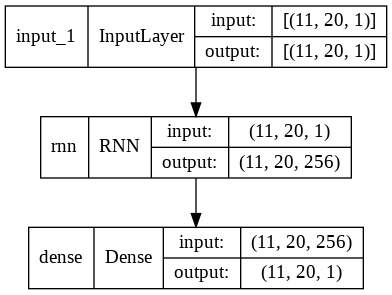

In [7]:
# Example: building a dRNN using the custom cell

# To have cross-batch statefulness set stateful = True
stateful = True

cell = DiagonalRNNCell(units=256)

inputs = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=batch_size)
layer = tf.keras.layers.RNN(cell, return_sequences=True, stateful=stateful)(inputs)
outputs = tf.keras.layers.Dense(1, activation='linear')(layer)


model = tf.keras.Model(inputs=inputs, outputs=outputs, name='dRNN')
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Optimization parameters

# Mean Squared Error for Regression
loss = tf.keras.losses.MSE 
# Learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [tf.metrics.MeanAbsoluteError()]

In [ ]:
# Compile Model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

## Batch Training (11 samples per batch, one for each frequency):
The model is trained with a either with "stateful" or a stateless RNN layer.

Weights are tuned after each batch of samples, which include different frequencies.

In [ ]:
# Training over all the dataset:

# Setting the number of training epochs
num_epochs = 50

for i in range(num_epochs):
    print('Epoch:' + ' ' + str(i+1))
    for batch in batches:
        metrics = model.train_on_batch(x=batch[0], y=batch[1], return_dict=True)
        print('  ' + 'Loss: ' + str(metrics['loss']))
        print('  ' + 'MAE: ' + str(metrics['mean_absolute_error']))
    if stateful:
        model.reset_states()
print("--------")  

In [ ]:
filename = 'dRNN_256_units_50_timesteps_stateful_True.h5'

# Saving the model weights
model.save_weights(filename, save_format='h5')

files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Store the model weights in a variable
model_weights = model.get_weights()

In [13]:
# Instantiating a prediction model to use a different batch size during prediction
batch_size_pred = 1 

cell = DiagonalRNNCell(units=256)

inputs = tf.keras.layers.Input(shape=(seq_len, 1,), batch_size=batch_size_pred)
layer = tf.keras.layers.RNN(cell, return_sequences=True, stateful=stateful)(inputs)
outputs = tf.keras.layers.Dense(1, activation='linear')(layer)

prediction_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='dRNN')
prediction_model.summary()

Model: "dRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(1, 20, 1)]              0         
                                                                 
 rnn_2 (RNN)                 (1, 20, 256)              768       
                                                                 
 dense_2 (Dense)             (1, 20, 1)                257       
                                                                 
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


Take the weights from the just trained model:

In [ ]:
prediction_model.set_weights(model_weights)

Download the weights of already trained models from the Github repository.

In [ ]:
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Trained%20Models/dRNN_256_units_20_timesteps_stateful_True.h5
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Trained%20Models/dRNN_256_units_20_timesteps_stateful_False.h5
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Trained%20Models/dRNN_256_units_50_timesteps_stateful_True.h5

Load the weights of an already trained model:

In [15]:
# Use alternatively: '/content/dRNN_256_units_20_timesteps_stateful_True.h5' or
#                    '/content/dRNN_256_units_20_timesteps_stateful_False.h5' or
#                    '/content/dRNN_256_units_50_timesteps_stateful_True.h5' 

prediction_model.load_weights('/content/dRNN_256_units_20_timesteps_stateful_True.h5')

# Prediction comparisons:

## dRNN with 256 units, 50 timesteps samples, stateful = True, 50 epochs



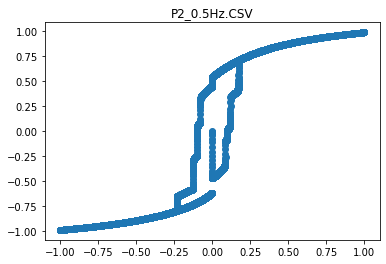

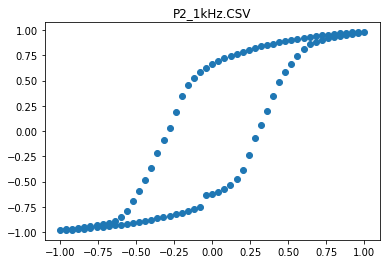

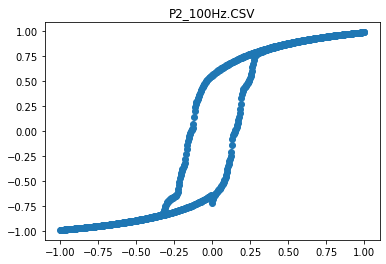

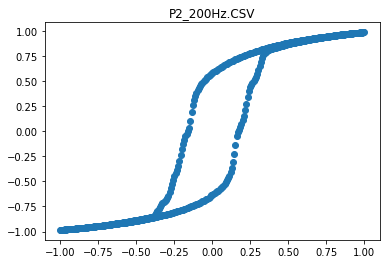

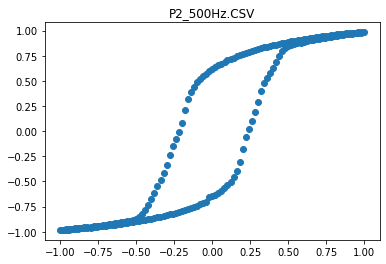

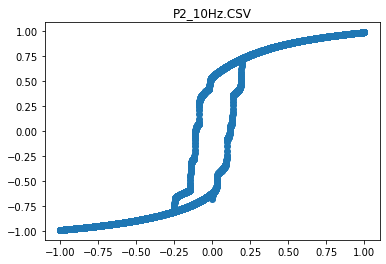

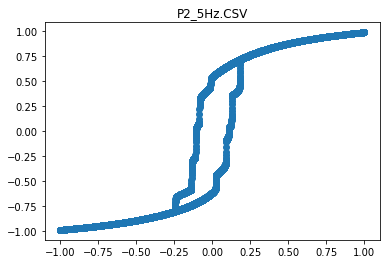

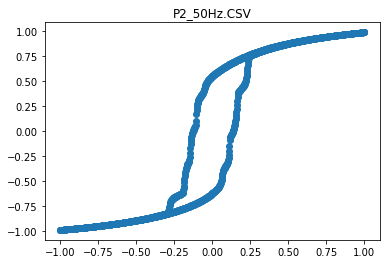

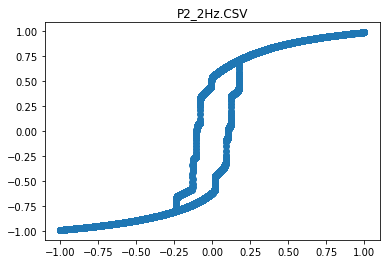

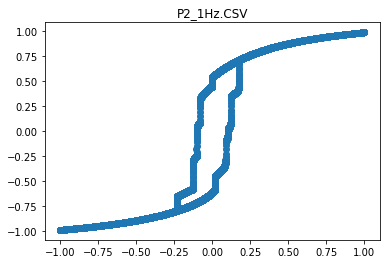

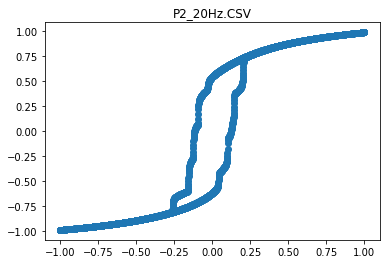

In [ ]:
# Testing the model on the training data itself, only to have an idea of what it is learning
y_pred = []

for freq in dataset:
    X_signal = np.array(dataset[freq][['H']])
    X = X_signal.reshape(-1, seq_len)
    y_pred = []
    for el in X:
        y_pred.append(prediction_model.predict(np.expand_dims(el, axis=0)))
    
    # Plot the prediction relative to a single input signal (at given frequency)
    plt.figure()
    plt.title(freq)
    plt.scatter(X_signal, y_pred)

## dRNN with 256 units, 20 timesteps samples, stateful = True, 50 epochs

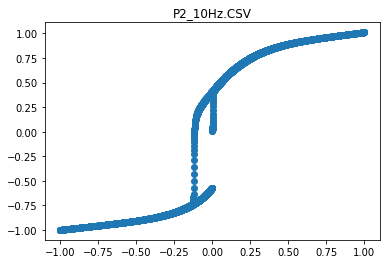

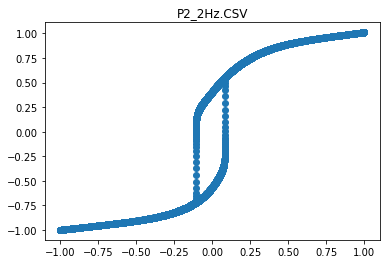

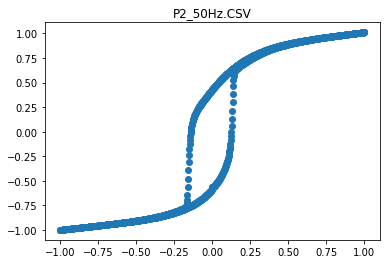

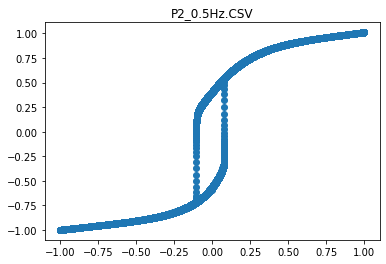

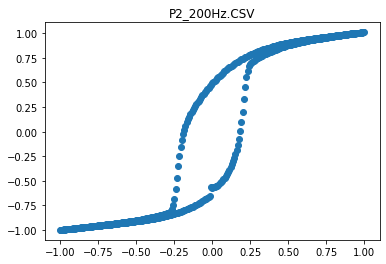

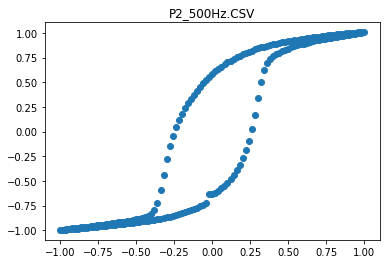

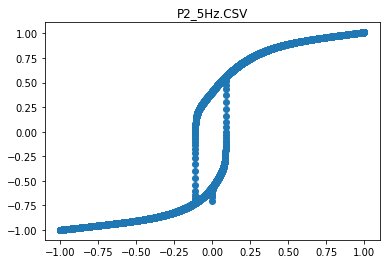

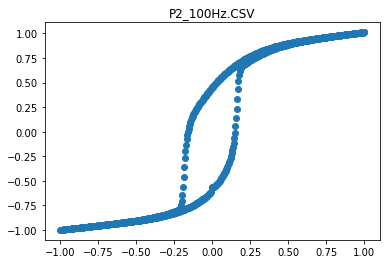

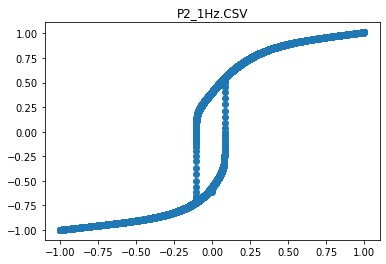

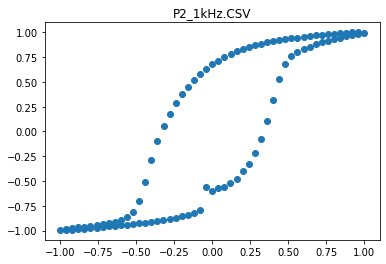

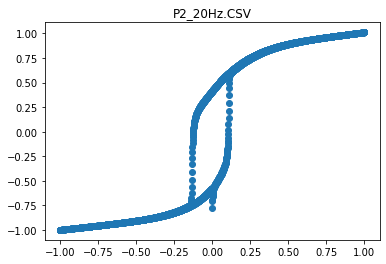

In [11]:
# Testing the model on the training data itself, only to have an idea of what it is learning
y_pred = []

for freq in dataset:
    X_signal = np.array(dataset[freq][['H']])
    X = X_signal.reshape(-1, seq_len)
    y_pred = []
    for el in X:
        y_pred.append(prediction_model.predict(np.expand_dims(el, axis=0)))
    
    # Plot the prediction relative to a single input signal (at given frequency)
    plt.figure()
    plt.title(freq)
    plt.scatter(X_signal, y_pred)

## dRNN with 256 units, 20 timesteps samples, stateful = False, 50 epochs

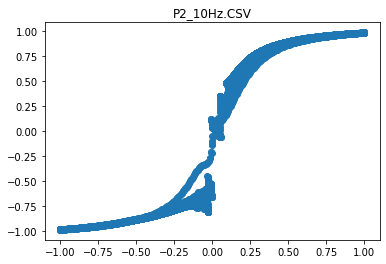

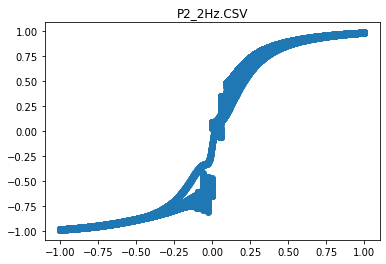

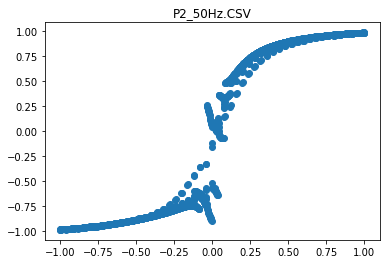

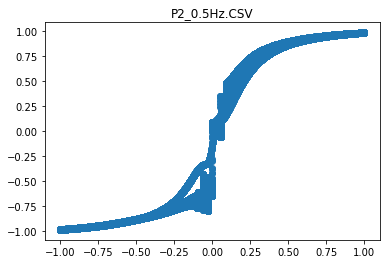

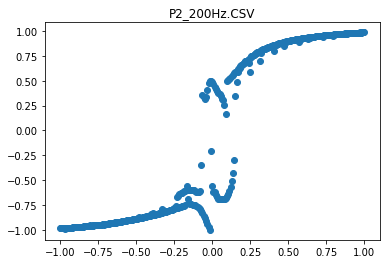

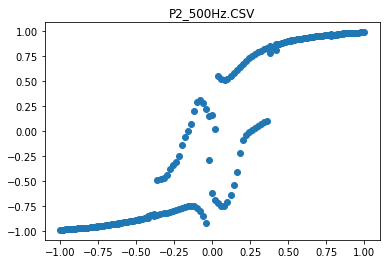

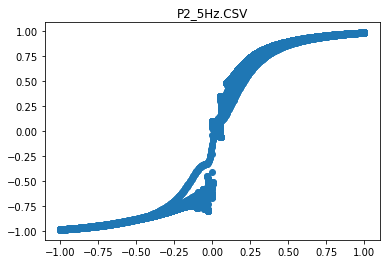

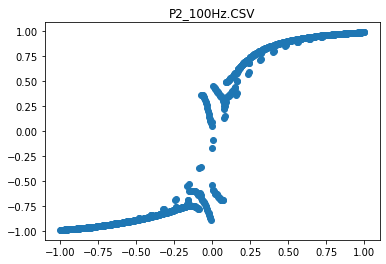

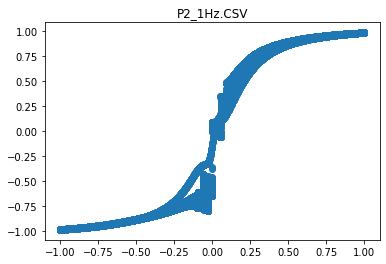

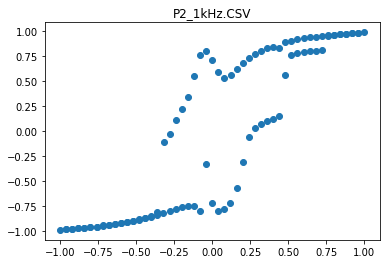

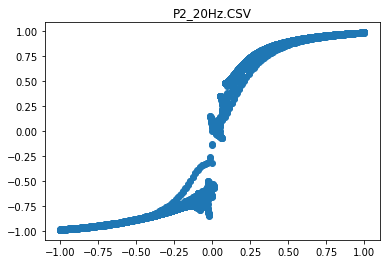

In [16]:
# Testing the model on the training data itself, only to have an idea of what it is learning
y_pred = []

for freq in dataset:
    X_signal = np.array(dataset[freq][['H']])
    X = X_signal.reshape(-1, seq_len)
    y_pred = []
    for el in X:
        y_pred.append(prediction_model.predict(np.expand_dims(el, axis=0)))
    
    # Plot the prediction relative to a single input signal (at given frequency)
    plt.figure()
    plt.title(freq)
    plt.scatter(X_signal, y_pred)

# TensorBoard
Opening a TensorBoard window to monitor the training procedure.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/logs # fix the path to the experiment directory